In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

plt.rcParams.update({'font.size': 15})

In [2]:
class TransformationPipeline:
    """Transformation pipeline for semi-supervised learning."""

    def __init__(self):
        """Define parameters."""
        pass

    def num_pipeline(self, X_train):
        """Transformation pipeline of data with only numerical variables.

        Parameters
        ----------
        X_train: training set

        Returns
        -------
        Transformation pipeline and transformed data in numpy array
        """
        # original numerical feature names
        feat_names = list(X_train.select_dtypes('number'))

        # create pipeline
        num_pipeline = Pipeline(
            [
                ('std_scaler', StandardScaler()),
            ]
        )
        # apply transformer
        X_train_scaled = num_pipeline.fit_transform(X_train)
        return X_train_scaled, feat_names

    def cat_encoder(self, X_train):
        """Encoder for categorical variables.

        Parameters
        ----------
        X_train: training set

        Returns
        -------
        Transformation pipeline and transformed data in array
        """
        # Instatiate class
        one_hot_encoder = OneHotEncoder()

        # Fit transform the training set
        X_train_scaled = one_hot_encoder.fit_transform(X_train)

        # Feature names for output features
        feat_names = list(
            one_hot_encoder.get_feature_names_out(
                list(X_train.select_dtypes('O'))
            )
        )
        return X_train_scaled.toarray(), feat_names

    def preprocessing(self, X_train):
        """Transformation pipeline of data with both numerical
        and categorical variables.

        Parameters
        ----------
        X_train: training set

        Returns
        -------
        Transformed data in array
        """

        # numerical transformation pipepline
        num_train, num_col = self.num_pipeline(X_train.select_dtypes('number'))

        # categorical transformation pipepline
        cat_train, cat_col = self.cat_encoder(X_train.select_dtypes('O'))

        # transformed training set
        X_train_scaled = np.concatenate((num_train, cat_train), axis=1)

        # feature names
        feat_names = num_col + cat_col
        return X_train_scaled, feat_names

    def pca_plot_labeled(self, X, labels, palette=None, ax=None):
        """Dimensionality reduction of labeled data using PCA.

        Parameters
        ----------
        X: transformed and scaled data
        labels: class labels
        palette: color list
        ax: matplotlib axes

        Returns
        -------
        Matplotlib plot of two component PCA
        """
        # PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        # put in dataframe
        X_reduced_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
        X_reduced_pca['class'] = labels

        # plot results
        sns.scatterplot(
            x='PC1',
            y='PC2',
            data=X_reduced_pca,
            hue='class',
            style='class',
            palette=palette,
            ax=ax,
        )

        # axis labels
        ax.set_xlabel('Principal component 1')
        ax.set_ylabel('Principal component 2')
        ax.legend(loc='best')

    def plot_pca(self, X_train, y_train, y_pred):
        """Plot PCA before and after semi-supervised classification.

        Parameters
        ----------
        X_train: scaled feature matrix of the training set
        y_train: original labels of the training set
        y_pred: predicted labels of the unlabeled data points

        Returns
        -------
        Matplotlib figure
        """
        # Plot figure
        plt.rcParams.update({'font.size': 15})
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

        self.pca_plot_labeled(
            X_train, y_train, palette=['gray', 'lime', 'r'], ax=ax1
        )
        self.pca_plot_labeled(X_train, y_pred, palette=['lime', 'r'], ax=ax2)
        ax1.set_title('PCA before semi-supervised classification')
        ax2.set_title('PCA after semi-supervised classification')



class SemiSupervised:
    """Semi-supervised learning classifiers."""

    def __init__(self):
        """Parameter initialization."""
        pass

    def self_training_clf(
        self,
        base_classifier,
        X_train,
        y_train,
        threshold=None,
        max_iter=None,
        verbose=None,
    ):
        """Train self-training classifier from scikit-learn >= 0.24.1.

        Parameters
        ----------
        base_classifier: supervised classifier implementing
        both fit and predict_proba
        X_train: scaled feature matrix of the training set
        y_train: class label of the training set
        threshold (float):  the decision threshold for
        use with criterion='threshold'. Should be in [0, 1)
        max_iter (int):  maximum number of iterations allowed.
        Should be greater than or equal to 0
        verbose (bool): enable verbose output

        Returns
        -------
        predicted labels and probability
        """
        # self training model
        model = SelfTrainingClassifier(
            base_classifier,
            threshold=threshold,
            max_iter=max_iter,
            verbose=verbose,
        )

        # fit the training set
        model.fit(X_train, y_train)

        # predict the labels of the unlabeled data points
        predicted_labels = model.predict(X_train)

        # predict probability
        predicted_proba = model.predict_proba(X_train)
        return predicted_labels, predicted_proba

    def label_spread(self, X_train, y_train, gamma=None, max_iter=None):
        """Train Label Spreading model from scikit-learn

        Parameters
        ----------
        X_train: scaled training data
        y_train: class label
        gamma: parameter for rbf kernel
        max_iter: maximum number of iterations allowed

        Returns
        -------
        Predicted labels and probability
        """
        # label spreading model
        model = LabelSpreading(
            kernel='rbf', gamma=gamma, max_iter=max_iter, n_jobs=-1
        )

        # fit the training set
        model.fit(X_train, y_train)

        # predict the labels of the unlabeled data points
        predicted_labels = model.transduction_

        # predict probability
        predicted_proba = model.predict_proba(X_train)
        return predicted_labels, predicted_proba

    def eval_metrics(self, y_true, y_pred, model_nm=None):
        """Evaluation metric using the ground truth and the predicted labels.

        Parameters
        ----------
        y_pred: predicted labels
        y_true: true labels
        model_nm: name of classifier

        Returns
        -------
        Performance metrics
        """
        print(f'Test predictions for {str(model_nm)}')
        print('-' * 60)
        print('Accuracy:  %f' % (accuracy_score(y_true, y_pred)))
        print('AUROC: %f' % (roc_auc_score(y_true, y_pred)))
        print('AUPRC: %f' % (average_precision_score(y_true, y_pred)))
        print('Predicted classes:', np.unique(y_pred))
        print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))
        print(
            'Classification report:\n', classification_report(y_true, y_pred)
        )
        print('-' * 60)

    def plot_varying_threshold(self, base_classifier, X_train, y_train):
        """Plot the effect of varying threshold for self-training.

        Parameters
        ----------
        base_classifier: supervised classifier implementing
        both fit and predict_proba
        X_train: scaled feature matrix of the training set
        y_train: class label of the training set

        Returns
        -------
        Matplotlib figure
        """
        total_samples = y_train.shape[0]
        x_values = np.arange(0.4, 1.05, 0.05)
        x_values = np.append(x_values, 0.99999)
        no_labeled = np.zeros(x_values.shape[0])
        no_iterations = np.zeros(x_values.shape[0])
        for (i, threshold) in enumerate(x_values):
            # fit model with chosen base classifier
            self_training_clf = SelfTrainingClassifier(
                base_classifier, threshold=threshold
            )
            self_training_clf.fit(X_train, y_train)

            # the number of labeled samples that the classifier
            # has available by the end of fit
            no_labeled[i] = (
                total_samples
                - np.unique(
                    self_training_clf.labeled_iter_, return_counts=True
                )[1][0]
            )

            # the last iteration the classifier labeled a sample in
            no_iterations[i] = np.max(self_training_clf.labeled_iter_)

        # plot figures
        plt.rcParams.update({'font.size': 15})
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
        ax1.plot(x_values, no_labeled, color='b')
        ax1.set_xlabel('Threshold')
        ax1.set_ylabel('Number of labeled samples')
        ax2.plot(x_values, no_iterations, color='b')
        ax2.set_ylabel('Number of iterations')
        ax2.set_xlabel('Threshold')
        plt.show()


In [3]:
# Instantiate the class
transfxn = TransformationPipeline()
model = SemiSupervised()

# Load data

In [4]:
df = pd.read_csv('A://Downloads//anomaly-detection-master//data//kdd99-unsupervised-ad.csv', header=None)
print("Data size:", df.shape) # print data size
df.columns = ['v_{}'.format(i) for i in range(30)] 
# df = (df.sample(frac =1)).reset_index(drop = True) # Shuffle the data
df.head() # display the data

Data size: (620098, 30)


,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_20,v_21,v_22,v_23,v_24,v_25,v_26,v_27,v_28,v_29
0,0.0,215.0,45076.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,n
1,0.0,162.0,4528.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,n
2,0.0,236.0,1228.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,n
3,0.0,233.0,2032.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,n
4,0.0,239.0,486.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,n


# Categorical variables encoded as integers

In [5]:
# Convert to string
cols = ['v_6', 'v_7', 'v_8', 'v_9']
for i, val in enumerate(cols):
    df[val] = df[val].astype('O')

# Create feature matrix and class label

In [6]:
X, y = df.drop('v_29', axis = 1), df.v_29

# Create unlabeled dataset
In this section, we remove some labels and relabel them as unknown, which is indicated by -1

In [7]:
# Map to binary
y_ = y.map({'n':0, 'o':1})

In [8]:
X_u, X_l, y_u, y_l = train_test_split(X,y_, test_size=0.08, stratify=y_, random_state=42)

In [9]:
unlabeled_set = list(X_u.index) # unlabeled indices
y_train = np.copy(y_) # copy labels
y_train[unlabeled_set] = -1 # set unlabeled dataset to -1
y_true = y_[unlabeled_set] # True labels of the unlabeled dataset

In [10]:
print("Original class distribution")
print('-'*25)
label_pct = y_.map({0:'normal',1: 'attack'}).value_counts()*100/len(y_)
label_ct =  y_.map({0:'normal',1: 'attack'}).value_counts()
pd.DataFrame(
    {
        'labels': label_pct.index, 
        'count': label_ct.values, 
        'percentage': label_pct.values,
    }
)

Original class distribution
-------------------------


,labels,count,percentage
0,normal,619046,99.830349
1,attack,1052,0.169651


In [11]:
print("Class distribution for semi-supervised learning")
print('-'*45)
label_pct = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})\
                .value_counts(normalize=True)*100
label_ct =  pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'}).value_counts()
pd.DataFrame(
    {
        'labels': label_pct.index, 
        'count': label_ct.values,
        'percentage': label_pct.values,
    }
)

Class distribution for semi-supervised learning
---------------------------------------------


,labels,count,percentage
0,unknown,570490,91.999974
1,normal,49524,7.986480
2,attack,84,0.013546


In [12]:
print(" Class distribution for true labels of the unlabeled dataset")
print('-'*45)
label_pct = y_true.map({0:'normal',1: 'attack'}).value_counts()*100/len(y_true)
label_ct =  y_true.value_counts()
pd.DataFrame(
    {
        'labels': label_pct.index, 
        'count': label_ct.values,
        'percentage': label_pct.values,
    }
)

 Class distribution for true labels of the unlabeled dataset
---------------------------------------------


,labels,count,percentage
0,normal,569522,99.830321
1,attack,968,0.169679


# Transformation pipeline

In [13]:
# Transform and scale data
X_train_scaled, feat_nm = transfxn.preprocessing(X)

In [14]:
print(f'Training set size after pre-processing: {X_train_scaled.shape, y_train.shape}')

Training set size after pre-processing: ((620098, 33), (620098,))


#  Self-Training Semi-Supervised Learning

# A-1. Logistic Regression

In [15]:
lr_base_classifier = LogisticRegression(random_state = 42)
lr_y_pred, y_proba = model.self_training_clf(
    lr_base_classifier, X_train_scaled, y_train,
    threshold=0.75, max_iter=None,verbose=True
)

print('-' * 40)
print(f"Predicted labels for {len(y_true)} unlabeled data points:")
pd.Series(lr_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 570476 new labels.
End of iteration 2, added 9 new labels.
----------------------------------------
Predicted labels for 570490 unlabeled data points:


0    569515
1       975
dtype: int64

# A-1-1. Performance metrics

We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [16]:
model.eval_metrics(y_true.values, lr_y_pred[unlabeled_set], 
                        model_nm='Logistic Regression')

Test predictions for Logistic Regression
------------------------------------------------------------
Accuracy:  0.999946
AUROC: 0.993785
AUPRC: 0.968379
Predicted classes: [0 1]
Confusion matrix:
 [[569503     19]
 [    12    956]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569522
           1       0.98      0.99      0.98       968

    accuracy                           1.00    570490
   macro avg       0.99      0.99      0.99    570490
weighted avg       1.00      1.00      1.00    570490

------------------------------------------------------------


# A-1-2. PCA plot

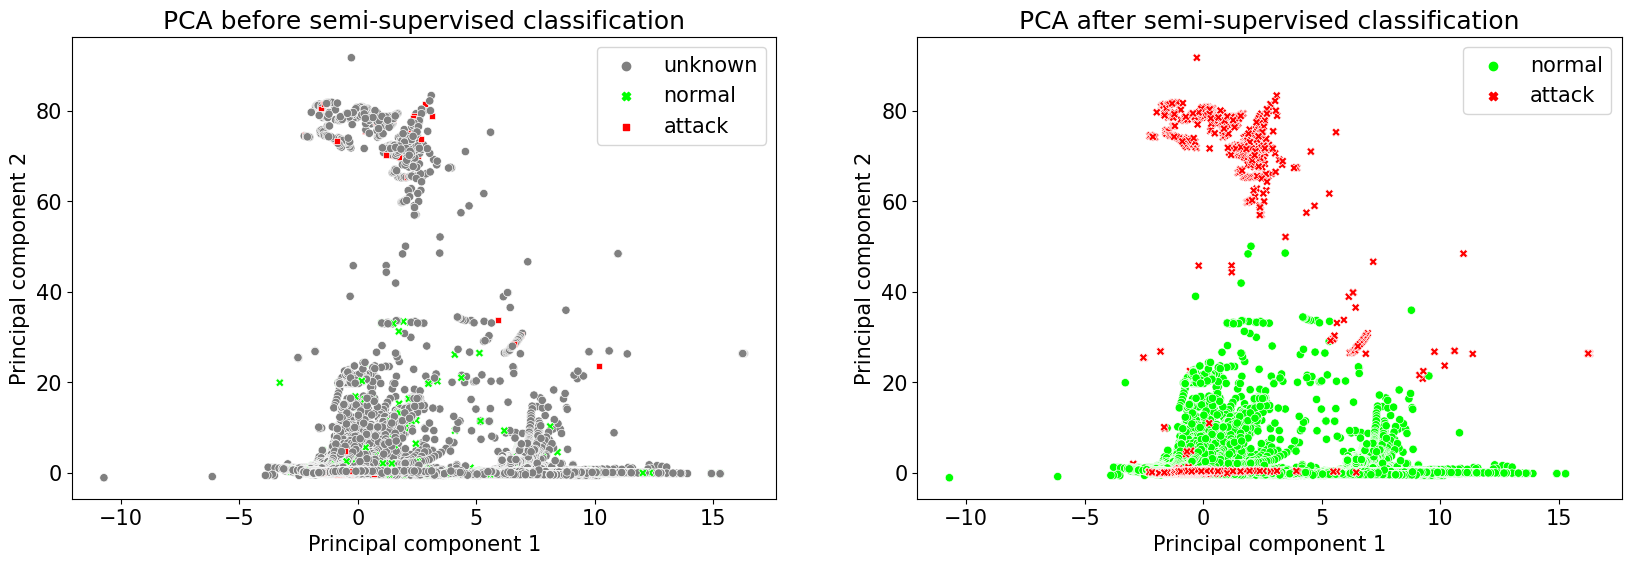

In [17]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
lr_y_pred = pd.Series(lr_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, lr_y_pred)

# A-2. Random Forest

In [18]:
param_dist = {'n_estimators':100, 'random_state':42}
rf_base_classifier = RandomForestClassifier(**param_dist)
rf_y_pred, y_proba = model.self_training_clf(
    rf_base_classifier, X_train_scaled, y_train,
    threshold=0.75, max_iter=None,verbose=True
)

print('-' * 40)
print(f"Predicted labels for {len(y_true)} unlabeled data points:")
pd.Series(rf_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 570406 new labels.
End of iteration 2, added 32 new labels.
End of iteration 3, added 4 new labels.
End of iteration 4, added 4 new labels.
End of iteration 5, added 1 new labels.
End of iteration 6, added 3 new labels.
----------------------------------------
Predicted labels for 570490 unlabeled data points:


0    569549
1       941
dtype: int64

# A-2-1. Performance metrics
We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [19]:
model.eval_metrics(y_true.values, rf_y_pred[unlabeled_set],
                     model_nm='Random Forest Classifier')

Test predictions for Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.999949
AUROC: 0.985536
AUPRC: 0.970092
Predicted classes: [0 1]
Confusion matrix:
 [[569521      1]
 [    28    940]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569522
           1       1.00      0.97      0.98       968

    accuracy                           1.00    570490
   macro avg       1.00      0.99      0.99    570490
weighted avg       1.00      1.00      1.00    570490

------------------------------------------------------------


# A-2-2. PCA plot

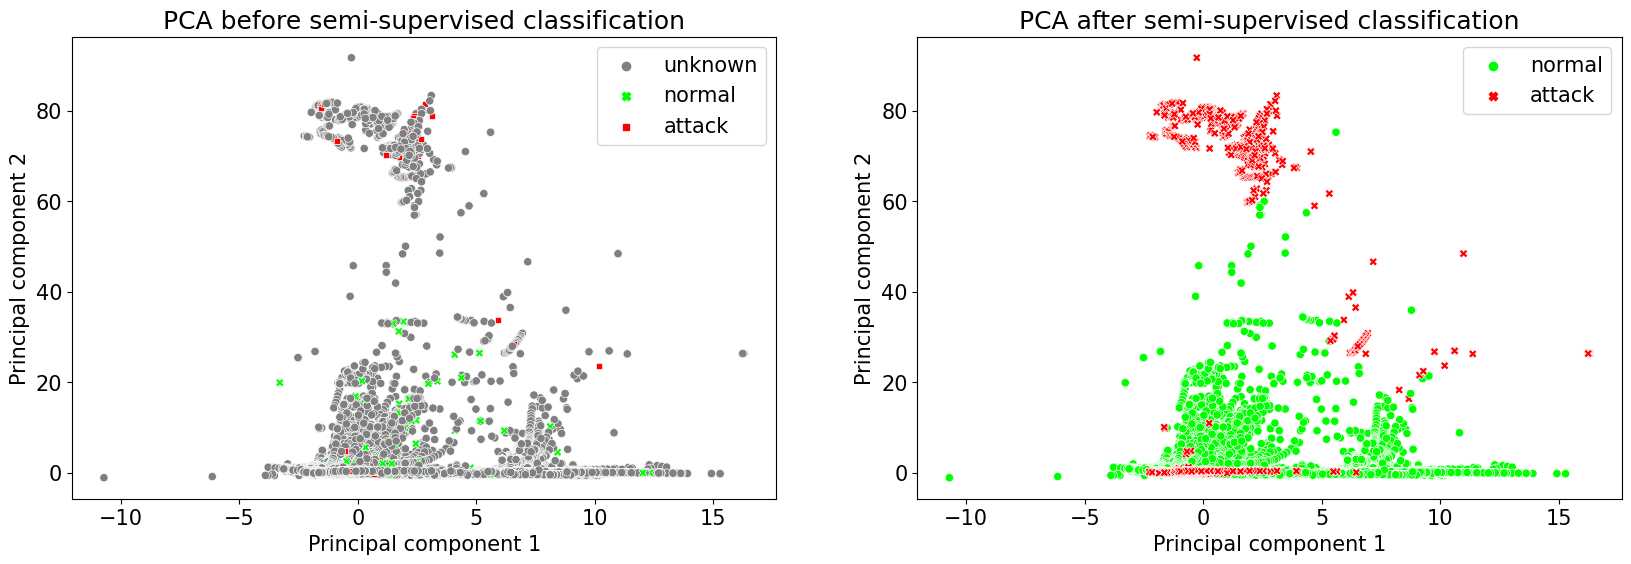

In [20]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
rf_y_pred = pd.Series(rf_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, rf_y_pred)

# A-3. XGBoost

In [21]:
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 
              'n_estimators':100, 'learning_rate':0.1, 'random_state':42
            }
                
xgb_base_classifier = XGBClassifier(**param_dist)
xgb_y_pred, y_proba = model.self_training_clf(xgb_base_classifier, X_train_scaled, y_train,
                                          threshold= 0.75, max_iter = None,verbose = True)
print('-' * 40)
print(f"Predicted labels for {len(y_true)} unlabeled data points:")
pd.Series(xgb_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 570473 new labels.
End of iteration 2, added 17 new labels.
----------------------------------------
Predicted labels for 570490 unlabeled data points:


0    569518
1       972
dtype: int64

# A-3-1. Performance metrics
We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [22]:
model.eval_metrics(y_true.values, xgb_y_pred[unlabeled_set],
                     model_nm='XGBoost Classifier')

Test predictions for XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.999944
AUROC: 0.992753
AUPRC: 0.967311
Predicted classes: [0 1]
Confusion matrix:
 [[569504     18]
 [    14    954]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569522
           1       0.98      0.99      0.98       968

    accuracy                           1.00    570490
   macro avg       0.99      0.99      0.99    570490
weighted avg       1.00      1.00      1.00    570490

------------------------------------------------------------


# A-3-2. PCA plot

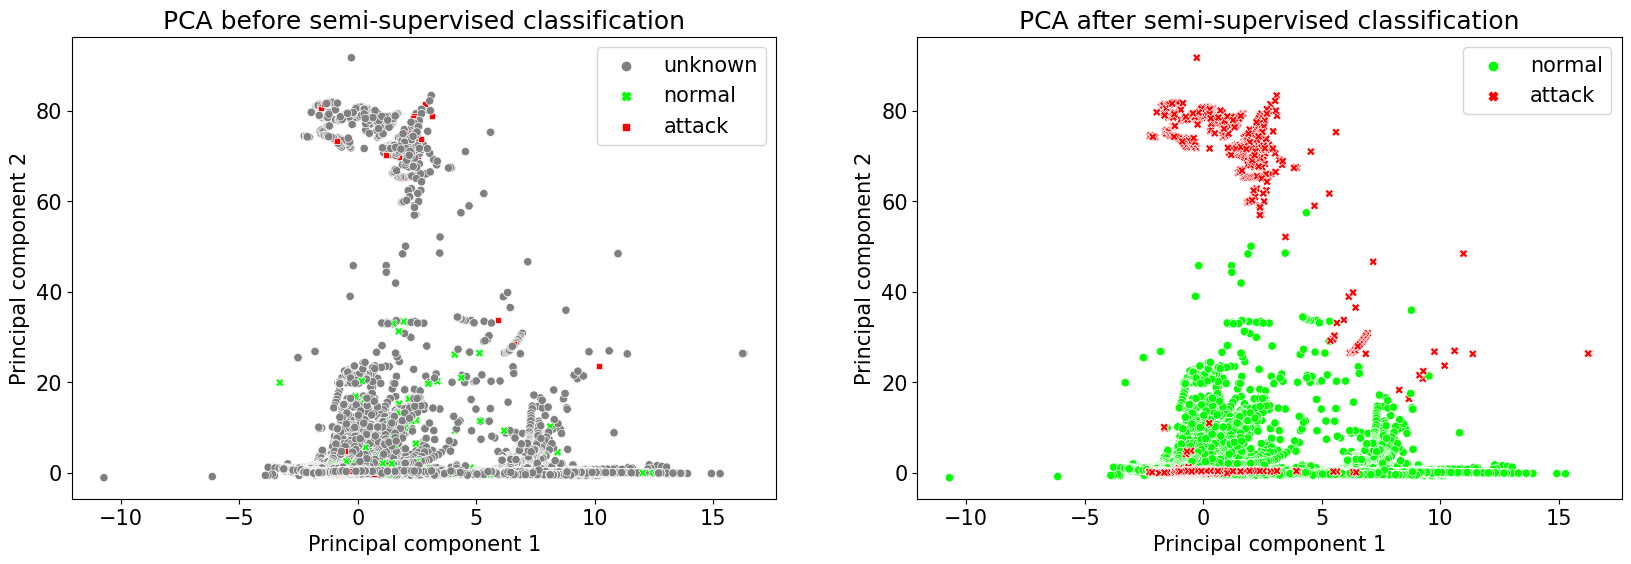

In [23]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
xgb_y_pred = pd.Series(xgb_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, xgb_y_pred)

In [24]:
data = pd.read_csv("A:\\Downloads\\anomaly-detection-master\\data\\kdd99-unsupervised-ad.csv")

data.columns = ['v_{}'.format(i) for i in range(30)] 
# df = (df.sample(frac =1)).reset_index(drop = True) # Shuffle the data
data.head() # display the data

# Split the data into training and testing sets
train = data.sample(frac=0.8, random_state=123)
test = data.drop(train.index)

# Define the features and target variable
features = ['v_0','v_1','v_2','v_3']
target = "v_29"
train[features]

test[target]

4         n
5         n
12        n
20        n
26        n
         ..
620074    o
620087    o
620088    o
620089    o
620095    o
Name: v_29, Length: 124019, dtype: object

In [25]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=123)
rf.fit(train[features], train[target])


train[target] = train[target].map({'n':0, 'o':1})


xgb = XGBClassifier(n_estimators=100, max_depth=5, random_state=123)
xgb.fit(train[features], train[target])


from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft')
ensemble.fit(train[features], train[target])


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=5,
                                                     random_state=123)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=123, ...))],
                 voting='soft')

In [26]:
y_pred = ensemble.predict(test[features])
test[target] = test[target].map({'n':0, 'o':1})
cm = confusion_matrix(test[target], y_pred)
print(cm)


[[123819      0]
 [   106     94]]


In [27]:
test[target]

4         0
5         0
12        0
20        0
26        0
         ..
620074    1
620087    1
620088    1
620089    1
620095    1
Name: v_29, Length: 124019, dtype: int64

In [33]:
lr = LogisticRegression()
ensemble = VotingClassifier(estimators=[('lr', lr), ('xgb', xgb)], voting='soft')


ensemble.fit(train[features], train[target])

y_pred = ensemble.predict(test[features])



accuracy = accuracy_score(test[target], y_pred)
print("Accuracy:", accuracy)
cm = confusion_matrix(test[target], y_pred)
print(cm)

Accuracy: 0.9991291656923535
[[123819      0]
 [   108     92]]


In [34]:
ensemble = VotingClassifier(estimators=[('lr', lr), ('rf', rf)], voting='soft')


ensemble.fit(train[features], train[target])

y_pred = ensemble.predict(test[features])



accuracy = accuracy_score(test[target], y_pred)
print("Accuracy:", accuracy)
cm = confusion_matrix(test[target], y_pred)
print(cm)

Accuracy: 0.9991291656923535
[[123819      0]
 [   108     92]]
